# Tfrecord

于Tensorflow读取数据，官网给出了三种方法：
* 供给数据(Feeding)： 在TensorFlow程序运行的每一步， 让Python代码来供给数据。
* 从文件读取数据： 在TensorFlow图的起始， 让一个输入管线从文件中读取数据。
* 预加载数据： 在TensorFlow图中定义常量或变量来保存所有数据(仅适用于数据量比较小的情况)。
于数据量较小而言，可能一般选择直接将数据加载进内存，然后再分batch输入网络进行训练（tip:使用这种方法时，结合yield 使用更为简洁，）。但是，如果数据量较大，这样的方法就不适用了，因为太耗内存，所以这时最好使用tensorflow提供的队列queue，也就是第二种方法 从文件读取数据。使用tensorflow内定标准格式——TFRecords。

从宏观来讲，tfrecord其实是一种数据存储形式。使用tfrecord时，实际上是先读取原生数据，然后转换成tfrecord格式，再存储在硬盘上。而使用时，再把数据从相应的tfrecord文件中解码读取出来。那么使用tfrecord和直接从硬盘读取原生数据相比到底有什么优势呢？其实，Tensorflow有和tfrecord配套的一些函数，可以加快数据的处理。实际读取tfrecord数据时，先以相应的tfrecord文件为参数，创建一个输入队列，这个队列有一定的容量（视具体硬件限制，用户可以设置不同的值），在一部分数据出队列时，tfrecord中的其他数据就可以通过预取进入队列，并且这个过程和网络的计算是独立进行的。也就是说，网络每一个iteration的训练不必等待数据队列准备好再开始，队列中的数据始终是充足的，而往队列中填充数据时，也可以使用多线程加速。

相关链接
* (https://blog.csdn.net/happyhorizion/article/details/77894055)
* (https://blog.csdn.net/u010358677/article/details/70544241)
* (https://blog.csdn.net/Best_Coder/article/details/70146441)

In [1]:
import os 
import tensorflow as tf 
from PIL import Image  
import matplotlib.pyplot as plt
import matplotlib.image as plImage
import numpy as np

把图片及标签存入tfrecord

In [2]:
tfwriter = tf.python_io.TFRecordWriter('dog_cat.tfrecords')
cwd = 'sourceImage/'
classes = ['dog','cat']
for class_ in classes:
    classpath = cwd + class_ + '/'
    for name_ in os.listdir(classpath):
        img_path = classpath + name_
        # 如果习惯用matplotlib.image，也是可以的，它也有tobytes()方法
        img = Image.open(img_path)
        img = img.resize((100,100))
        # 已经移除了toString()方法，用tobytes()方法
        img_raw = img.tobytes()
        example = tf.train.Example(features=tf.train.Features(feature={
            'label':tf.train.Feature(bytes_list = tf.train.BytesList(value=[class_.encode()])),
            'img_raw':tf.train.Feature(bytes_list = tf.train.BytesList(value=[img_raw]))
        }))
        tfwriter.write(example.SerializeToString())
tfwriter.close()

从tfrecord文件读取图片存到本地

In [3]:
outPath = 'outImage/'
if not os.path.exists(outPath):
    os.makedirs(outPath)
#文件读入流中
filename_queue = tf.train.string_input_producer(["dog_cat.tfrecords"])
reader = tf.TFRecordReader()
# 返回文件名和文件
_, serialized_example = reader.read(filename_queue)
# 取出包含image和label的features对象
features = tf.parse_single_example(serialized_example,
                                  features={
                                      'label':tf.FixedLenFeature([], tf.string),
                                      'img_raw':tf.FixedLenFeature([], tf.string)
                                  })
image = tf.decode_raw(features['img_raw'], tf.uint8)
image = tf.reshape(image, [100,100,3])
label = features['label']

with tf.Session() as sess:
    init_op = tf.group(tf.global_variables_initializer(),tf.local_variables_initializer())
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)
    for i in range(18):
        # 取出image和label
        example, l  = sess.run([image,label])
        img = Image.fromarray(example,'RGB')
        img.save(outPath + l.decode() + '_' + str(i) + '.jpg')
        print(l)
    coord.request_stop()
    coord.join(threads)

b'dog'
b'dog'
b'dog'
b'dog'
b'dog'
b'dog'
b'dog'
b'dog'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'
b'cat'


### 展示标准读取代码
* 注释掉的部分为对图像进行随机增强的部分，这种思路很好，增大数据量
* 关于注释掉的 if shuffle_batch部分的代码，写的不好。因为每次调用read_and_decode()函数，都会解析tfrecord文件，这样浪费算力，代码也会因为部分原因停掉

In [2]:
def read_and_decode(filename_queue, random_crop=False, random_clip=False, shuffle_batch=True):
    reader = tf.TFRecordReader()
    _, serialized_example = reader.read(filename_queue)
    features = tf.parse_single_example(serialized_example,
                                      features={
                                          'label':tf.FixedLenFeature([], tf.string),
                                          'img_raw':tf.FixedLenFeature([], tf.string)
                                      })
    label = features['label']
    image = tf.decode_raw(features['img_raw'],tf.uint8)
    image = tf.reshape(image,[100,100,3])
    
#    if random_crop:
#        image = tf.random_crop(image, [227, 227, 3])
#    else:
#        image = tf.image.resize_image_with_crop_or_pad(image, 227, 227)

#    if random_clip:
#        image = tf.image.random_flip_left_right(image)

#     if shuffle_batch:
#         images, labels = tf.train.shuffle_batch([image, label], 
#                                                 batch_size=3, 
#                                                 capacity=100,
#                                                 num_threads=2,
#                                                 min_after_dequeue=20)
#     else:
#         images, labels = tf.train.batch([image, label],
#                                        batch_size=3,
#                                        capacity=100,
#                                        num_threads=2,
#                                        min_after_dequeue=20)
    return image, label
                                    

* 主函数部分

batch0:
cat


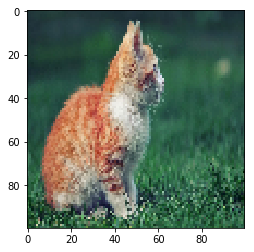

cat


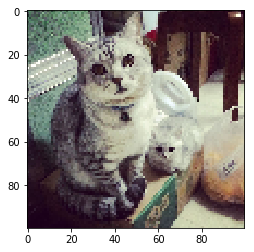

dog


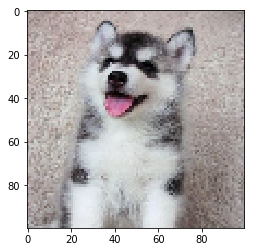

batch1:
dog


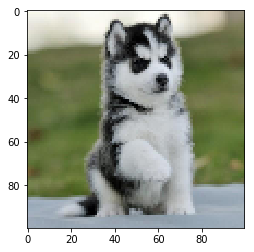

cat


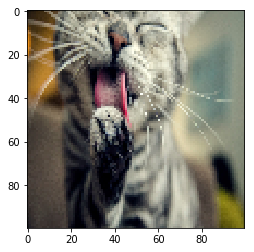

cat


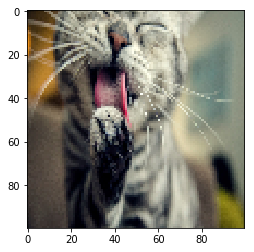

batch2:
dog


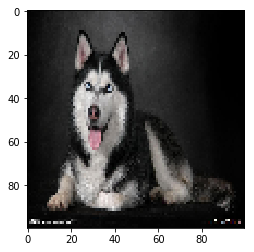

dog


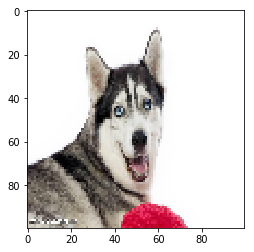

dog


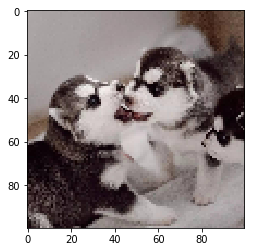

batch3:
cat


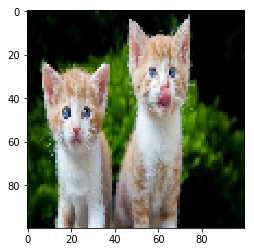

cat


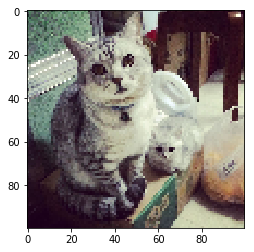

cat


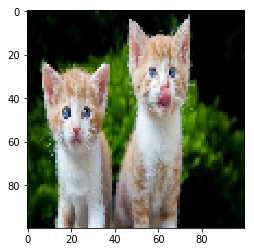

batch4:
dog


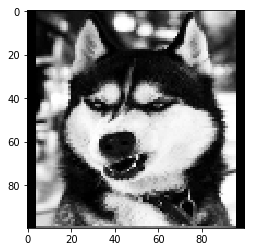

cat


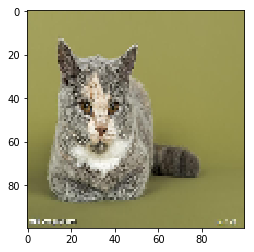

cat


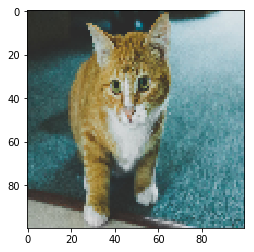

batch5:
cat


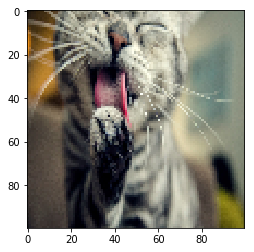

dog


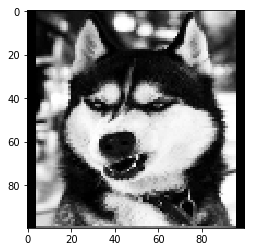

cat


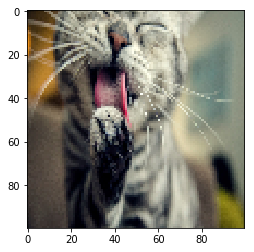

batch6:
dog


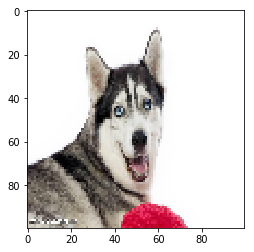

cat


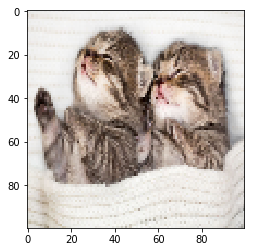

cat


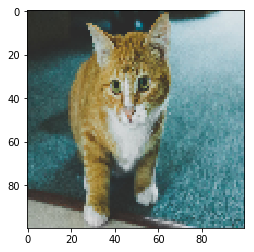

batch7:
dog


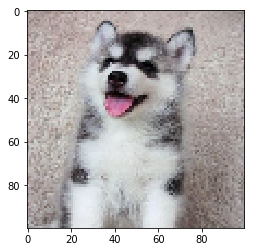

cat


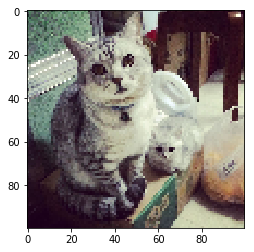

dog


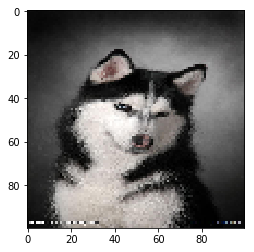

batch8:
cat


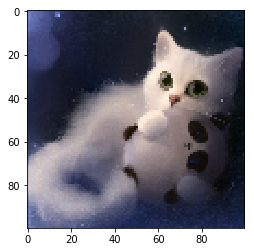

dog


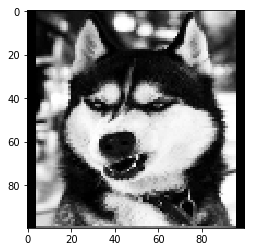

cat


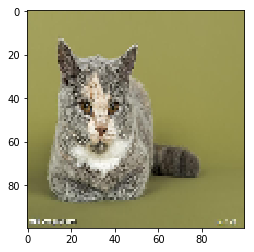

batch9:
cat


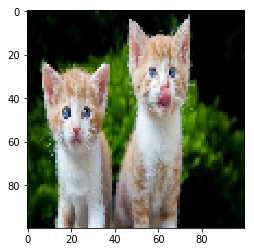

cat


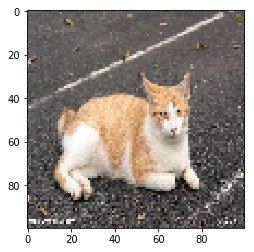

dog


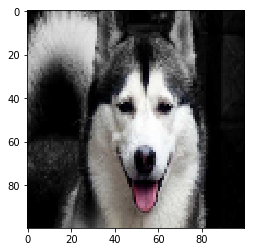

In [3]:
SHUFFLE = True
# 可以指定eopch，在每个epoch内不重复
filename_queue = tf.train.string_input_producer(['dog_cat.tfrecords'],num_epochs=10)
images, labels = read_and_decode(filename_queue)

if SHUFFLE:
    image_b, label_b = tf.train.shuffle_batch([images, labels],
                                             batch_size=10,
                                             capacity=100,
                                             num_threads=2,
                                             min_after_dequeue=20)
else:
    image_b, label_b = tf.train.batch([images, labels],
                                             batch_size=10,
                                             capacity=100,
                                             num_threads=2,
                                             min_after_dequeue=20)

init_op = tf.group(tf.global_variables_initializer(),
                  tf.local_variables_initializer())
with tf.Session() as sess:
    sess.run(init_op)
    coord = tf.train.Coordinator()
    threads = tf.train.start_queue_runners(coord=coord)

    for i in range(10):
        img_,label_ = sess.run([image_b, label_b])
        print('batch' + str(i) + ':')
        for j in range(3):
            print(label_[j].decode())
            img_toshow = np.uint(img_[j])
            plt.imshow(img_toshow)
            plt.show()
    
    coord.request_stop()
    coord.join(threads)